# 機械学習 勉強会
- 20210707

## 要件
- データセットはcipher10を使い、testデータの精度が大きくなるようCNNを組んでください
- 精度は同じモデルで5回学習し、各回のaccuracyの平均値を取るものとします
- CNNは教科書のp.456, 457を基本とするが、ResnetResnetなどを組んでもよい（ただし、自力で組むこと）
- 精度が計算できたらチャットで共有しましょう

## 詳細
- hands-on-ml ~~p.299,~~ 456
- ~~fasion-mnistとC~~NN
- validとtrainは分けない
- train 
- test
- ハイパーパラメータ
    - 層のサイズ
    - ドロップアウト
    - denseなどは変える
    - 活性化関数
    - パディング
- 20エポック


## CIFAR-10
- 10種類の「物体カラー写真」（乗り物や動物など）の画像データセット
- オブジェクト認識用画像データセット「80 Million Tiny Images」から収集
- https://www.atmarkit.co.jp/ait/articles/2006/10/news021.html

## 1. setup
### 1.1 import
- see [14_deep_computer_vision_with_cnns.ipynb](https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1.2 def plot func

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## 1.3 import cifar-10
see [Google Colab+KerasでCNNを爆速構築](https://qiita.com/kazukiii/items/7979c8f8de9908a01166)

In [3]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### 1.3.1 test cifar-10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


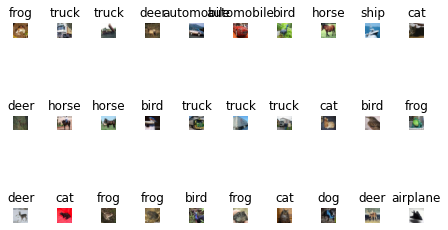

In [4]:
import matplotlib.pyplot as plt

# ラベルのリストを定義
cifar10_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

# 描写
for index, img in enumerate(X_train[:30]):
    plt.subplot(3, 10, index + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(cifar10_labels[y_train[index][0]])
    plt.tight_layout()

plt.show()


## 2. data preprocessing
### 2.1 normalize features

In [5]:
# 特徴量の正規化
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

### 2.2 class label 2 one-hot-vec

In [6]:
from keras.utils import np_utils

# クラスラベルのone-hot-vector化
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

## 3. make CNN model

In [7]:
# 必要なものをimport
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.optimizers import Adam

from keras.layers.core import Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.callbacks import TensorBoard

# モデルを定義
model=Sequential()

# 層を追加していく
model.add(Conv2D(32,(3,3),padding='same',input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten()) # 平坦化
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))

# コンパイル
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# TensorBoardで結果を見るためのインスタンス化
tsb = TensorBoard(log_dir='./logs')

## 4. train

### ~~4.0 calc accuracy ave on each epoch~~
- [Keras Documentation](https://keras.io/ja/callbacks/#baselogger)
- [Keras Callbacks – BaseLogger](https://theailearner.com/2019/07/23/keras-callbacks-baselogger/)

In [8]:
# First, create an instance of this BaseLogger class
# from keras.callbacks import BaseLogger
# call = BaseLogger(stateful_metrics= ['acc'])

#Then pass this as a list in the fit() method
# record = model.fit(..., callbacks=[call],...)

# record.history['acc']

### 4.1 save weight
see [Reset/Reinitialize model weights/parameters #341](https://github.com/keras-team/keras/issues/341)

In [9]:
Wsave = model.get_weights()

### 4.2 do train

In [10]:
# 学習
for _ in range(5):
    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=20,
        # epochs=5,
        validation_split=0.2,
        callbacks=[tsb]
        # callbacks=[call]
    )

model.set_weights(Wsave)

Epoch 1/20
1250/1250 [==============================] - 24s 7ms/step - loss: 1.7927 - accuracy: 0.3338 - val_loss: 1.1440 - val_accuracy: 0.5912
Epoch 2/20
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1643 - accuracy: 0.5863 - val_loss: 0.9540 - val_accuracy: 0.6658
Epoch 3/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.9897 - accuracy: 0.6497 - val_loss: 0.8552 - val_accuracy: 0.7002
Epoch 4/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.8671 - accuracy: 0.6978 - val_loss: 0.7983 - val_accuracy: 0.7261
Epoch 5/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.8008 - accuracy: 0.7192 - val_loss: 0.7702 - val_accuracy: 0.7336
Epoch 6/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.7276 - accuracy: 0.7433 - val_loss: 0.7191 - val_accuracy: 0.7509
Epoch 7/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.6737 - accuracy: 0.7615 - val_loss: 0.6891 - val_accuracy

In [18]:
model.evaluate(X_test, y_test)

AttributeError: ignored

## 5. adjust hyper-params for accuracy

### 5.1 change batch_size not to 2^n (failed)
- change 32 to 30
- accuracy 0.71 to 0.6236

In [11]:
history = model.fit(
    X_train,
    y_train,
    # batch_size=32,
    batch_size=300,
    epochs=5,
    validation_split=0.2,
    callbacks=[tsb]
)

model.set_weights(Wsave)

Epoch 1/5
134/134 [==============================] - 5s 31ms/step - loss: 1.8943 - accuracy: 0.3038 - val_loss: 1.6118 - val_accuracy: 0.4225
Epoch 2/5
134/134 [==============================] - 3s 25ms/step - loss: 1.4760 - accuracy: 0.4632 - val_loss: 1.2778 - val_accuracy: 0.5408
Epoch 3/5
134/134 [==============================] - 3s 25ms/step - loss: 1.2777 - accuracy: 0.5416 - val_loss: 1.1412 - val_accuracy: 0.6049
Epoch 4/5
134/134 [==============================] - 3s 25ms/step - loss: 1.1583 - accuracy: 0.5871 - val_loss: 1.0540 - val_accuracy: 0.6297
Epoch 5/5
134/134 [==============================] - 3s 25ms/step - loss: 1.0702 - accuracy: 0.6222 - val_loss: 0.9588 - val_accuracy: 0.6594


# 5.2 EfficientNet
- [帰ってきたResNet！最新の画像認識モデル「ResNet-RS」を解説！](https://qiita.com/omiita/items/0c2176a1edc26d69e2c9#4-%E3%81%BE%E3%81%A8%E3%82%81%E3%81%A8%E6%89%80%E6%84%9F)
- ~~[EfficientNetを用いた画像分類モデルを学習させるまで。](https://kagglenote.com/ml-tips/efficientnet/)~~
- [ViTとEfficientnetをCIFAR-10で試してみた]()

In [12]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-fx5yon9g
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-fx5yon9g
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp37-none-any.whl size=18436 sha256=e9c11a4d789067e0aa7e3147fb8cd25f0fad6071d22e0b6f6d786f327ba9650f
  Stored in directory: /tmp/pip-ephem-wheel-cache-w9l10xm_/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1


In [13]:
keras.__version__

'2.5.0'

In [ ]:
# 再現性確保
import os
os.environ['PYTHONHASHSEED'] = '0'
import tensorflow as tf

import numpy as np
import random as rn

SEED = 123
def reset_random_seeds():
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    rn.seed(SEED)

reset_random_seeds()

# ライブラリインポート
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization,Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from efficientnet.tfkeras import EfficientNetB0 #使用するモデルにあわせて変更する（B0~B7） 
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# import tensorflow_addons as tfa # error

# from vit_keras import vit, utils # error

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
import datetime

# CIFAR-10のインポート
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 変数定義
image_size = 32   #画像のサイズ（CIFAR-10は32×32）
input_shape=(image_size,image_size,3)
num_classes = 10 #画像の種類の数（CIFAR-10は10種類）

# モデル定義
## Efficientnetモデルの定義（ファインチューニング）
def buildModel():
    model_ef = Sequential()
    model_ef.add(EfficientNetB0(    #使用するモデルにあわせて変更する（B0~B7） 
        include_top=False,
        weights='imagenet',
        input_shape=input_shape))
    model_ef.add(GlobalAveragePooling2D())
    model_ef.add(Dense(num_classes, activation="softmax"))
    model_ef.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model_ef

# 訓練用関数の定義
## efficientnet用訓練関数
def train_efficientnet(X, y, steps_per_epoch, epochs, batch_size, callbacks):
    # 訓練データと評価データの分割
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)

    # Data Augmentation
    datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, width_shift_range=0.2, zoom_range=0.2)
    train_generator = datagen.flow(X_train, y_train,batch_size=batch_size)

    # モデル構築
    model_ef = buildModel()

    # 学習
    history_ef = model_ef.fit_generator(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks,
                        shuffle=True
                       )
    
    return model_ef, history_ef

# 訓練開始
# steps_per_epoch = 1250
# epochs = 1000
# batch_size = 32
steps_per_epoch = 1250
# epochs = 5
epochs = 20
batch_size = 32

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.2,patience=2,verbose=1,
                              min_delta=1e-4,min_lr=1e-6,mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5,
                                                 mode='max', verbose=1)
callbacks = [earlystopping, reduce_lr]

print('開始時間：',datetime.datetime.now())
# 以下はvitの場合。Efficientnetの場合はtrain_efficientnet()を呼び出す。
# model_ef, history_ef = train_vit(x_train, y_train, steps_per_epoch, epochs, batch_size, callbacks)
for _ in range(5):
    model_ef, history_ef = train_efficientnet(x_train, y_train, steps_per_epoch, epochs, batch_size, callbacks)
    print('終了時間：',datetime.datetime.now())

# 予測
preds = []
X = x_test
pred = model_ef.predict(X)

# 予測結果の確認
df_pred = pd.DataFrame(pred)
pred = np.array(df_pred.idxmax(axis=1))
df_pred = pd.DataFrame(pred)
df_y = pd.DataFrame(y_test)
df_result = pd.concat([df_y, df_pred], axis=1, join_axes=[df_y.index])
df_result.columns = ['y','pred']
print(df_result)

# 予測結果の評価（混合行列、Accuracy、Precision、Recall、F_score）
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Confusion Matrix:')
print(confusion_matrix(df_result['y'],df_result['pred']))
print('Accuracy :{:.4f}'.format(accuracy_score(df_result['y'],df_result['pred'])))
print('Precision:{:.4f}'.format(precision_score(df_result['y'],df_result['pred'],average='macro')))
print('Recall   :{:.4f}'.format(recall_score(df_result['y'],df_result['pred'],average='macro')))
print('F_score  :{:.4f}'.format(f1_score(df_result['y'],df_result['pred'],average='macro')))


開始時間： 2021-07-07 03:20:33.240631


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1250/1250 [==============================] - 120s 59ms/step - loss: 1.7142 - accuracy: 0.4040 - val_loss: 1.2031 - val_accuracy: 0.5812
Epoch 2/20
1250/1250 [==============================] - 72s 57ms/step - loss: 1.2196 - accuracy: 0.5737 - val_loss: 0.9821 - val_accuracy: 0.6556
Epoch 3/20
1250/1250 [==============================] - 72s 57ms/step - loss: 1.0421 - accuracy: 0.6363 - val_loss: 0.8375 - val_accuracy: 0.7142
Epoch 4/20
1250/1250 [==============================] - 72s 57ms/step - loss: 0.9426 - accuracy: 0.6709 - val_loss: 0.7693 - val_accuracy: 0.7331
Epoch 5/20
1250/1250 [==============================] - 72s 57ms/step - loss: 0.8701 - accuracy: 0.6962 - val_loss: 0.7212 - val_accuracy: 0.7538
Epoch 6/20
1250/1250 [==============================] - 74s 59ms/step - loss: 0.8078 - accuracy: 0.7198 - val_loss: 0.6517 - val_accuracy: 0.7786
Epoch 7/20
1250/1250 [==============================] - 74s 59ms/step - loss: 0.7699 - accuracy: 0.7311 - val_loss: 0.6301 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
  18/1250 [..............................] - ETA: 1:11 - loss: 2.6489 - accuracy: 0.1198

valid を使ってしまっている

In [ ]:
model_ef.evaluate(x_test, y_test, verbose=1)

## 報告
- evaluateを使えていない
- 簡単なCNN
    - 学習時のAccuracy：0.9243
- EfficientNet：Rethinking Model Scaling for Convolutional Neural Networks
　　- 数件の記事を見たところ、精度が良さそうなCNNモデル
    - 現在、30分で2回目の学習が終わりそう
　　- validの除去を忘れていた